In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
import json
from timebudget import timebudget
sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [2]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
gmm_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/gmm_fits_us/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
E_names_file = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/E_names.json'
O = sio.loadmat(origdata_pth,squeeze_me=True)


#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
fiton='zT'
n_cvfolds = 44

#Load all CV sets 
with timebudget('load all cv sets'):
    CVdict={}
    key_list = ['XrT','XrT_from_XE','XrE','XrE_from_XT','train_ind','val_ind','test_ind']

    for cv in range(n_cvfolds):
        cvfold_fname='v3_Edat_pcipfx_aT_'+str(alpha_T)+\
                    '_aE_'+str(alpha_E)+\
                    '_cs_'+str(lambda_TE)+\
                    '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                    '_ri_0500_ft-summary'
        cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X

load all cv sets took 10.251sec


In [3]:
npp_genes = ['Vip','Npy','Sst','Penk','Tac2','Cck','Crh',
             'Tac1','Pdyn','Cort','Pthlh','Pnoc','Adcyap1',
             'Trh','Grp','Nmb','Nts','Rln1','Vipr1','Vipr2',
             'Npy1r','Npy2r','Npy5r','Sstr1','Sstr2',
             'Sstr3','Sstr4','Oprd1','Oprm1','Tacr3',
             'Cckbr','Crhr1','Crhr2','Tacr1','Oprk1',
             'Pth1r','Oprl1','Adcyap1r1','Trhr','Trhr2',
             'Grpr','Nmbr','Ntsr1','Ntsr2','Rxfp1','Rxfp2',
             'Rxfp3']

gene_list = npp_genes

#Find location of all genes
gene_inds = []
for gene in gene_list:
    ind = np.flatnonzero(np.isin(O['gene_id'],gene))
    if ind.size==1:
        gene_inds.append(ind[0])
gene_inds = np.array(gene_inds)
genes_found = O['gene_id'][gene_inds].tolist()

In [4]:
not_found=list(set(gene_list)-set(genes_found))
len(not_found)
not_found

['Pth1r',
 'Vipr2',
 'Oprk1',
 'Ntsr2',
 'Trh',
 'Trhr2',
 'Tacr3',
 'Nmb',
 'Rxfp2',
 'Grpr',
 'Sstr3']

In [5]:
csTE = '1-0'
aE = '1-0'

cv_list = CVdict.keys()
XrT = np.concatenate([CVdict[cv]['XrT'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrT_from_XE = np.concatenate([CVdict[cv]['XrT_from_XE'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrE = np.concatenate([CVdict[cv]['XrE'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrE_from_XT = np.concatenate([CVdict[cv]['XrE_from_XT'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)

val_ind = np.concatenate([CVdict[cv]['val_ind'] for cv in cv_list],axis=0)

In [6]:
O.keys()

dict_keys(['__header__', '__version__', '__globals__', 'T_dat', 'T_spec_id_label', 'T_ispaired', 'gene_id', 'cluster', 'cluster_id', 'cluster_color', 'sample_id', 'map_conf', 'E_pc_zscored', 'E_pc_scaled', 'E_feature', 'E_spec_id_label', 'E_ispaired', 'pc_name', 'feature_name', 'feature_mean', 'feature_std'])

In [7]:
O['E_dat']=np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
O['E_names']=np.concatenate([O['pc_name'],O['feature_name']],axis = 0)
with open(E_names_file) as f:
    temp = json.load(f)
O['E_names'] = np.array([temp[i] for i in O['E_names']])

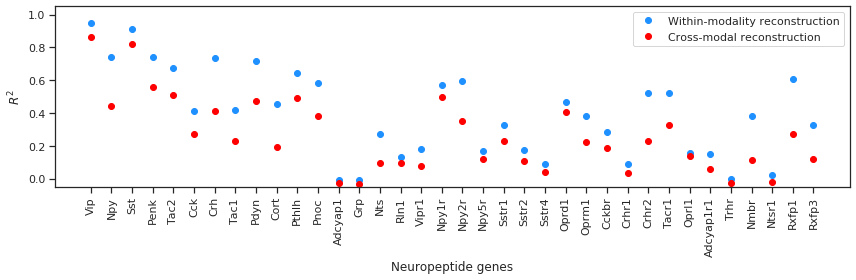

In [17]:
fig = plt.figure(figsize=(12,4))
mse_T_to_T = np.mean((O['T_dat'][val_ind,:] - XrT)**2,axis=0)/np.var(O['T_dat'][val_ind,:],axis=0)
mse_E_to_T = np.mean((O['T_dat'][val_ind,:] - XrT_from_XE)**2,axis=0)/np.var(O['T_dat'][val_ind,:],axis=0)
plt.plot(np.arange(len(genes_found)), 1 - mse_T_to_T[gene_inds],'o',color='dodgerblue',label='Within-modality reconstruction')
plt.plot(np.arange(len(genes_found)), 1 - mse_E_to_T[gene_inds],'o',color='red',label='Cross-modal reconstruction')
plt.legend()
ax = plt.gca()
ax.set_ylabel(r'$R^2$')
ax.set_xlabel('Neuropeptide genes')
ax.set_ylim(-0.05,1.05)
ax.set_xticks(np.arange(len(genes_found)))
ax.set_xticklabels(genes_found,rotation=90)
plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/R2_NPP_genes.png',dpi=300)

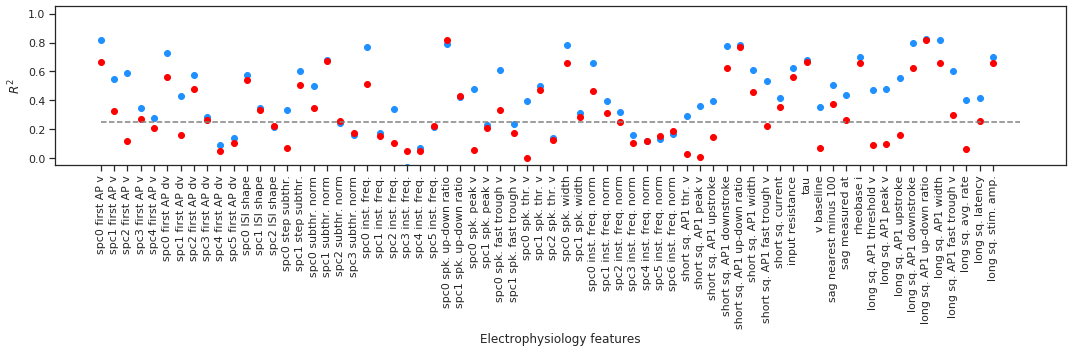

In [18]:
fig = plt.figure(figsize=(15,5))
mse_E_to_E = np.nanmean((O['E_dat'][val_ind,:] - XrE)**2,axis=0)/np.nanvar(O['E_dat'][val_ind,:],axis=0)
mse_T_to_E = np.nanmean((O['E_dat'][val_ind,:] - XrE_from_XT)**2,axis=0)/np.nanvar(O['E_dat'][val_ind,:],axis=0)
plt.plot(np.arange(O['E_names'].size), 1 - mse_E_to_E[:],'o',color='dodgerblue',label='within-modality reconstruction')
plt.plot(np.arange(O['E_names'].size), 1 - mse_T_to_E[:],'o',color='red',label='Cross-modal reconstruction')
plt.plot([0,69],[0.25,0.25],'--',color='gray')
ax = plt.gca()
ax.set_ylabel(r'$R^2$')
ax.set_ylim(-0.05,1.05)
ax.set_xlabel("Electrophysiology features")
ax.set_xticks(np.arange(O['E_names'].size))
ax.set_xticklabels(O['E_names'],rotation=90)
plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/R2_E_features.png',dpi=300)
plt.show()


In [19]:
R2_T_to_E = 1 - mse_T_to_E[:]

In [20]:
def get_merged_ordered_classes(data_labels,n_required_classes=30):
    """
    Exits when number of labels in the data matches or is just 
    above the required number of classes.
    
    returns:
    
    """
    from analysis_tree_helpers import HTree, do_merges

    #Load inhibitory subtree
    htree = HTree(htree_file='/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv')
    subtree = htree.get_subtree(node='n59')
    L = subtree.get_mergeseq()
    
    #Init:
    n_remain_classes = np.unique(data_labels).size
    n = 0
    
    while n_remain_classes>n_required_classes:
        n = n+1
        merged_sample_labels = do_merges(labels=data_labels.copy(), list_changes=L, n_merges=n, verbose=False)
        n_remain_classes = np.unique(merged_sample_labels).size
        
    if n_remain_classes!=n_required_classes:
        print('WARNING: Merges for required number of classes not found. Returning a higher number of classes')
        n = n-1
        
    new_data_labels = do_merges(labels=data_labels, list_changes=L, n_merges=n, verbose=False)
    print('Performed {:d} merges. Remaining classes in data = {:d}'.format(n,np.unique(new_data_labels).size))
    assert np.all(np.isin(np.unique(new_data_labels),subtree.child)), "Merged labels are not listed as children in tree"

    ind = np.isin(subtree.child,np.unique(new_data_labels))
    remain_class_names = subtree.child[ind]
    remain_class_x = subtree.x[ind]
    remain_class_names = sorted(list(set(zip(remain_class_names,remain_class_x))),key=lambda x:x[1])
    class_order = [n[0] for n in remain_class_names]
    return new_data_labels,class_order

In [21]:
n_required_classes = np.unique(O['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=O['cluster'].copy(),
                                                         n_required_classes=n_required_classes)

Performed 0 merges. Remaining classes in data = 59


**T cross modal data type wise**

In [22]:
A = pd.DataFrame(pd.Series(O['cluster']).value_counts(),columns={'counts'})
well_sampled_types = A.loc[A['counts']>10].index.values
t_types = [t for t in t_types if t in well_sampled_types]

In [23]:
err_E_to_T = []
true_vals = []
pred_vals = []

for t in t_types:
    this_type = t_type_labels[val_ind]==t
    err_E_to_T.append(np.mean((O['T_dat'][val_ind[this_type],:] - 
                                XrT_from_XE[this_type,:])**2,axis=0)/(np.nanvar(O['T_dat'][val_ind[this_type],:],axis=0)+0.001))

    true_vals.append(np.mean(O['T_dat'][val_ind[this_type],:],axis=0))
    pred_vals.append(np.mean(XrT_from_XE[this_type,:],axis=0))
    
err_E_to_T_type_wise = np.concatenate(np.expand_dims(err_E_to_T,0),axis=0)    
true_vals = np.concatenate(np.expand_dims(true_vals,0),axis=0)    
pred_vals = np.concatenate(np.expand_dims(pred_vals,0),axis=0)    

<Figure size 360x360 with 0 Axes>

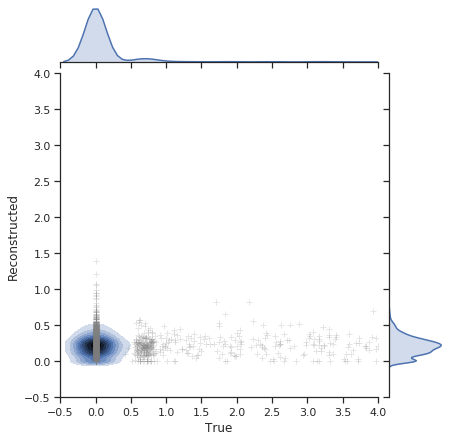

In [24]:
plt.figure(figsize=(5,5))
ii = 110#gene_inds[2]

g = sns.jointplot(x=O['T_dat'][val_ind,ii], y=XrT_from_XE[:,ii], kind="kde", color="b")
g.plot_joint(plt.scatter, c="gray", s=30, alpha=0.2, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)

ax = plt.gca()
ax.set_xlim(-0.5,4)
ax.set_ylim(-0.5,4)
ax.set_xlabel('True')
ax.set_ylabel('Reconstructed')
plt.show()


In [25]:
len(genes_found)

36

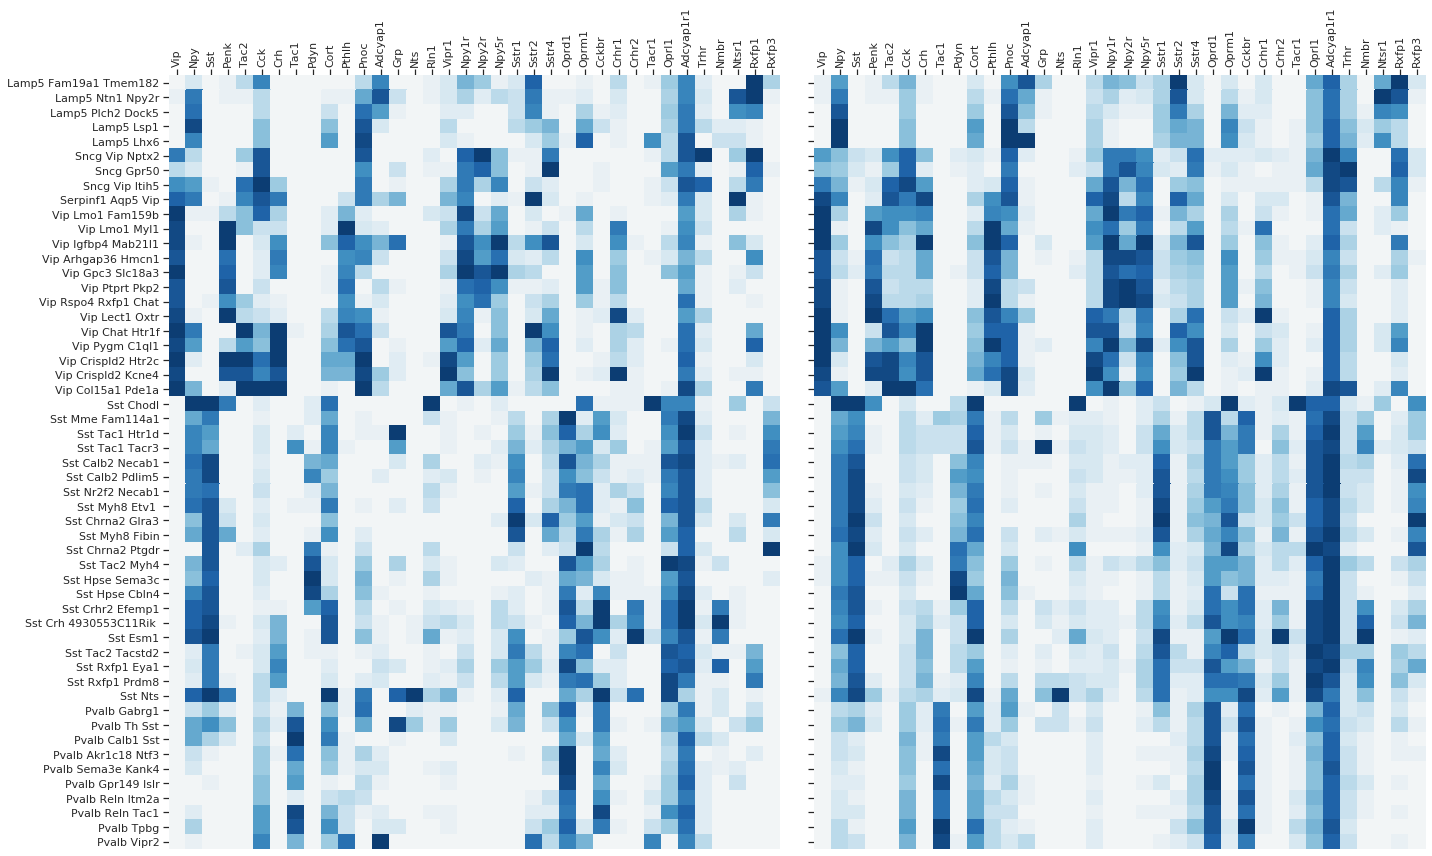

In [54]:
M_true = true_vals[:,gene_inds]/np.max(true_vals[:,gene_inds],axis=0)
M_pred = pred_vals[:,gene_inds]/np.max(pred_vals[:,gene_inds],axis=0)
xlabels = genes_found
ylabels = t_types

plt.figure(figsize = (20,12))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=-1,vmax=1,center=0,cbar=False,
            cmap=sns.color_palette("RdBu", 40),ax=ax)

ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)

ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=-1,vmax=1,center=0,cbar=False,
            cmap=sns.color_palette("RdBu", 40),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(['    ']*len(ylabels),rotation=0)

ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/T_dat_pred.png',dpi=300)

**E cross modal data type wise**

In [55]:
err_T_to_E = []
true_vals = []
pred_vals = []
for t in t_types:
    this_type = t_type_labels[val_ind]==t
    
    err_T_to_E.append(np.nanmean((O['E_dat'][val_ind[this_type],:] - 
                               XrE_from_XT[this_type,:])**2,axis=0)/(np.nanvar(O['E_dat'][val_ind[this_type],:],axis=0)+0.001))
    true_vals.append(np.nanmean(O['E_dat'][val_ind[this_type],:],axis=0))
    pred_vals.append(np.nanmean(XrE_from_XT[this_type,:],axis=0))

true_vals = np.concatenate(np.expand_dims(true_vals,0),axis=0)       
pred_vals = np.concatenate(np.expand_dims(pred_vals,0),axis=0)    

err_T_to_E_type_wise = np.concatenate(np.expand_dims(err_T_to_E,0),axis=0)

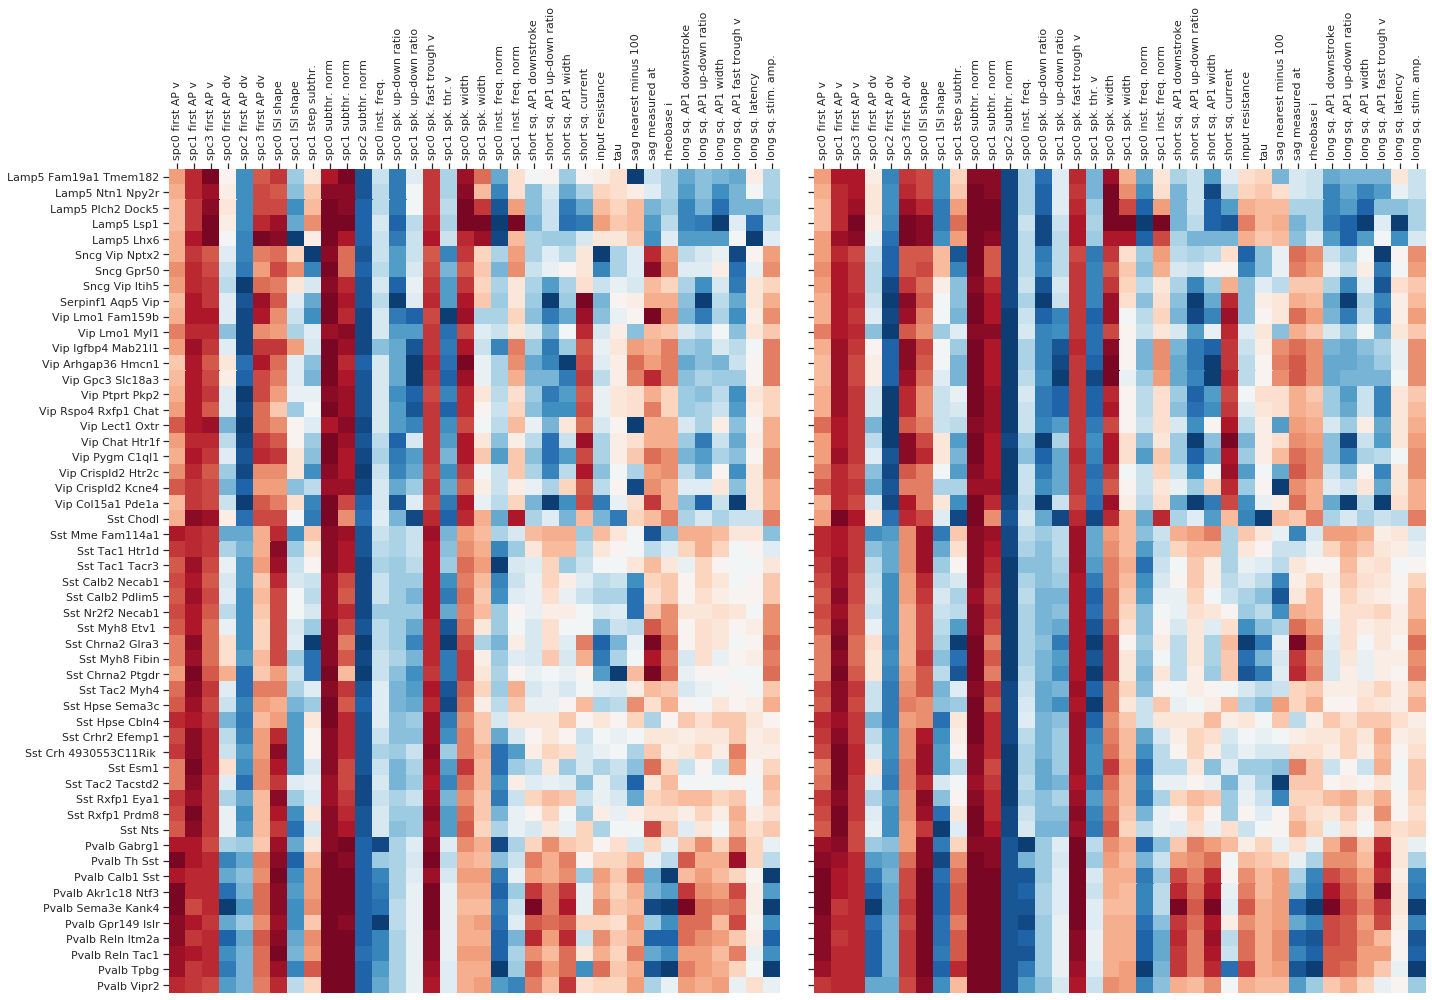

In [59]:
keep_feature_ind = R2_T_to_E>0.25
M_true = true_vals[:,keep_feature_ind]/np.max(np.abs(true_vals[:,keep_feature_ind]),axis=0)
M_pred = pred_vals[:,keep_feature_ind]/np.max(np.abs(pred_vals[:,keep_feature_ind]),axis=0)
xlabels = O['E_names'][keep_feature_ind]
ylabels = t_types


plt.figure(figsize = (20,14))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=-1,vmax=1,cbar=False,
            cmap=sns.color_palette("RdBu", 40))
#cbar_kws={"aspect":30,"shrink":.5,"use_gridspec":False,"location":"right"},
ax = plt.gca()
ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)

ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=-1,vmax=1,cbar=False,
            cmap=sns.color_palette("RdBu", 40),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(['    ']*len(ylabels),rotation=0)

ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/E_dat_pred.png',dpi=300)

In [50]:
t_types[-1]

'Pvalb Vipr2'

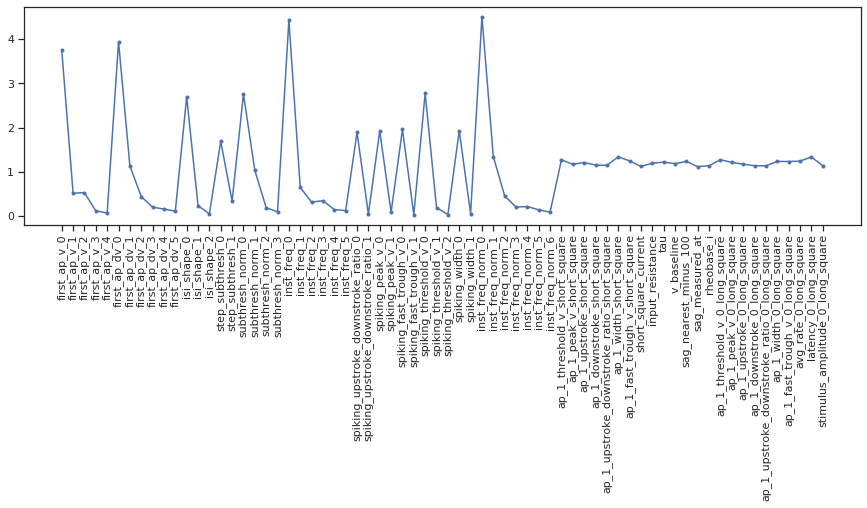

In [96]:
yy = np.nanvar(O['E_dat'],axis=0)
xx = np.arange(yy.size)
plt.figure(figsize=(15,4))
plt.plot(xx,yy,'.-')
ax = plt.gca()
ax.set_xticks(xx)
ax.set_xticklabels(xlabels,rotation=90)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,5))
mse_T_to_T = np.mean((O['E_dat'][val_ind,:] - XrT)**2,axis=0)/np.var(O['E_dat'][val_ind,:],axis=0)
mse_E_to_T = np.mean((O['E_dat'][val_ind,:] - XrT_from_XE)**2,axis=0)/np.var(O['E_dat'][val_ind,:],axis=0)
plt.plot(np.arange(len(genes_found)), mse_T_to_T[gene_inds],'.-',color='dodgerblue')
plt.plot(np.arange(len(genes_found)), mse_E_to_T[gene_inds],'.-',color='red')
ax = plt.gca()
ax.set_xticks(np.arange(len(genes_found)))
ax.set_xticklabels(genes_found,rotation=90)
plt.show()

In [13]:
csTE = '1-0'
aE = '1-0'
dir_pth={}
dir_pth['result'] = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
X = np.empty(shape=(9,gene_inds.size))
Y = np.empty(shape=(9,gene_inds.size))
for cv in range(9):
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    inds = np.ix_(D['val_ind'],gene_inds)
    X[cv,:] = np.mean(np.square(O['T_dat'][inds] - D['XrT'][inds]),axis=0)
    Y[cv,:] = np.mean(np.square(O['T_dat'][inds] - D['XrT_from_XE'][inds]),axis=0)

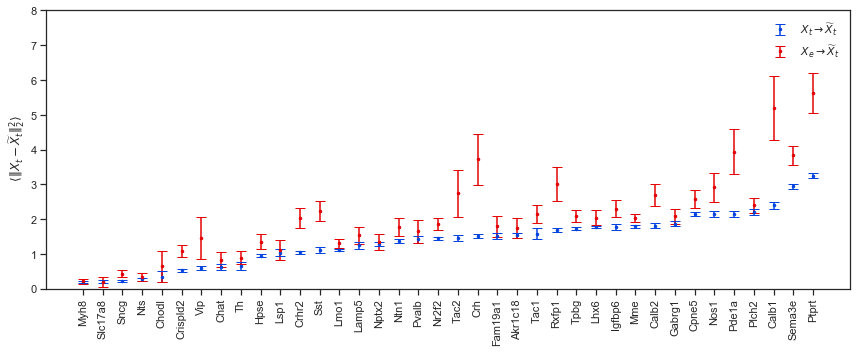

In [15]:
xx = np.arange(0,X.shape[1],1)

#With modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

#Cross modal prediction
yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)

cols = ['#0343df','#e50000']
fig = plt.figure(figsize=(12,5))

srtord = np.argsort(yy)
#srtord = np.arange(0,yy.size)
plt.errorbar(x=xx,y=yy[srtord],yerr=err[srtord],c=cols[0],capsize=5,ls='',marker='.',ms=5,label=r'$X_t \rightarrow \widetilde{X}_t$')
plt.errorbar(x=xx,y=yy2[srtord],yerr=err2[srtord],c=cols[1],capsize=5,ls='',marker='.',ms=5,label=r'$X_e \rightarrow \widetilde{X}_t$')
ax = plt.gca()
ax.set_xticks(np.arange(len(genes_found)))
genes_found_arr = np.array(genes_found)
ax.set_xticklabels(genes_found_arr[srtord],rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{t} - \widetilde{X}_{t} \Vert_2^2 \rangle $')
ax.set_ylim(0,8.0)
plt.legend(edgecolor='None')
plt.tight_layout()
fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Tpred_crossmodal_celltype_genes.png',dpi=300)

In [10]:
genesrtord = srtord
genesrtord = np.arange(0,srtord.size,1)

In [11]:
csTE = '1-0'
aE = '1-0'
dir_pth={}
dir_pth['result'] = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
cv=0
D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
#O['T_dat'][np.ix_(D['val_ind'],gene_inds)]

In [12]:
%matplotlib inline

In [14]:
gene_inds = gene_inds[genesrtord]

cell_ind=D['test_ind'][0]
for i in np.arange(0,D['test_ind'].size,1000):
    cell_ind=D['test_ind'][290]
    plt.figure(figsize = (10,4))

    h1=plt.bar(x=np.arange(gene_inds.size)-0.2,
            height=D['XrT'][cell_ind,gene_inds],
            edgecolor='None',
            width=0.35,
            color='#0343df',alpha=0.8,align='center',
            label=r'Reconstruction from representation: $z_{t} \rightarrow \widetilde{X}_t$')

    h2=plt.bar(x=np.arange(gene_inds.size)+0.2,
            height=D['XrT_from_XE'][cell_ind,gene_inds],
            edgecolor='None',
            width=0.35,
            color='#e50000',alpha=0.8,align='center',
            label=r'Cross-modal reconstruction: $X_{me} \rightarrow \widetilde{X}_t$')

    h3=plt.bar(x=np.arange(gene_inds.size),
            height=O['T_dat'][cell_ind,gene_inds],
            width=0.8,
            color=(0.3,0.3,0.3,0.1),edgecolor='k',linewidth=1.5,align='center',
            label=r'Ground truth: $X_t$')

    ax = plt.gca()
    #plt.text(.5,.9,O['cluster'][cell_ind],
    #        horizontalalignment='center',
    #        transform=ax.transAxes,fontsize=12)
    ax.set_xticks(np.arange(gene_inds.size))
    ax.set_xticklabels(genes_found_arr[genesrtord],rotation=90)
    ax.set_ylabel(r'$log_e(CPM+1)$')
    ax.set_ylim(0,11.0)
    plt.legend(handles=[h3,h1,h2],labels=[h3.get_label(),h1.get_label(),h2.get_label()],fontsize=15,
              edgecolor='None',framealpha=0.2)
    plt.tight_layout()

    #plt.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Test_T_'+str(i)+'_'+O['cluster'][cell_ind]+'.png',dpi=300)

    #---------------------------------------
    #---------------------------------------
    #Electrophysiology features-------------
    #---------------------------------------
    #---------------------------------------

    plt.figure(figsize = (12.5,5))

    h1=plt.bar(x=np.arange(len(E_feature_list))-0.2,
            height=D['XrE'][cell_ind,:],
            edgecolor='None',
            width=0.35,
            color='#0343df',alpha=0.8,align='center',
            label=r'Reconstruction from representation: $z_{me} \rightarrow \widetilde{X}_{me}$')

    h2=plt.bar(x=np.arange(len(E_feature_list))+0.2,
            height=D['XrE_from_XT'][cell_ind,:],
            width=0.35,
            color='#e50000',
            edgecolor='None',alpha=0.8,align='center',
            label=r'Cross-modal reconstruction: $X_{t} \rightarrow \widetilde{X}_{me}$')

    h3=plt.bar(x=np.arange(len(E_feature_list)),
               height=np.append(O['E_dat'][cell_ind,:],O['M_dat'][cell_ind]),
               width=0.8,
               color=(0.3,0.3,0.3,0.1),edgecolor='k',linewidth=1.5,align='center',
               label=r'Ground truth: $X_e$')

    ax = plt.gca()
    ax.set_xticks(np.arange(len(E_feature_list)))
    ax.set_xticklabels(E_feature_list,rotation=90)
    ax.set_ylabel(r'AU')
    ax.set_ylim(-3.5,3.5)
    plt.legend(handles=[h3,h1,h2],
              labels=[h3.get_label(),h1.get_label(),h2.get_label()],
              fontsize=15,
              edgecolor='None',framealpha=0.2)
    plt.tight_layout()
    #plt.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Test_E_'+str(i)+'_'+O['cluster'][cell_ind]+'.png',dpi=300)
    plt.close('all')

**Load all validation data and annotations**

In [10]:
%matplotlib inline

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 

In [12]:
csTE = '1-0'
aE = '1-0'
dir_pth={}
dir_pth['result'] = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
raw_data_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'

XrE = []
XrT = []
XrE_from_XT = []
XrT_from_XE = []
valind = []
for cv in range(9):
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    valind.append(D['val_ind'])
    XrE.append(D['XrE'][D['val_ind'],:])
    XrT.append(D['XrT'][D['val_ind'],:])
    XrE_from_XT.append(D['XrE_from_XT'][D['val_ind'],:])
    XrT_from_XE.append(D['XrT_from_XE'][D['val_ind'],:])
valind = np.concatenate(valind,axis=0)
XrE = np.concatenate(XrE,axis=0)
XrT = np.concatenate(XrT,axis=0)
XrE_from_XT = np.concatenate(XrE_from_XT,axis=0)
XrT_from_XE = np.concatenate(XrT_from_XE,axis=0)

In [13]:
O = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)

In [14]:
from analysis_tree_helpers import HTree, Node, get_valid_classifications
import scipy.io as sio
import pandas as pd

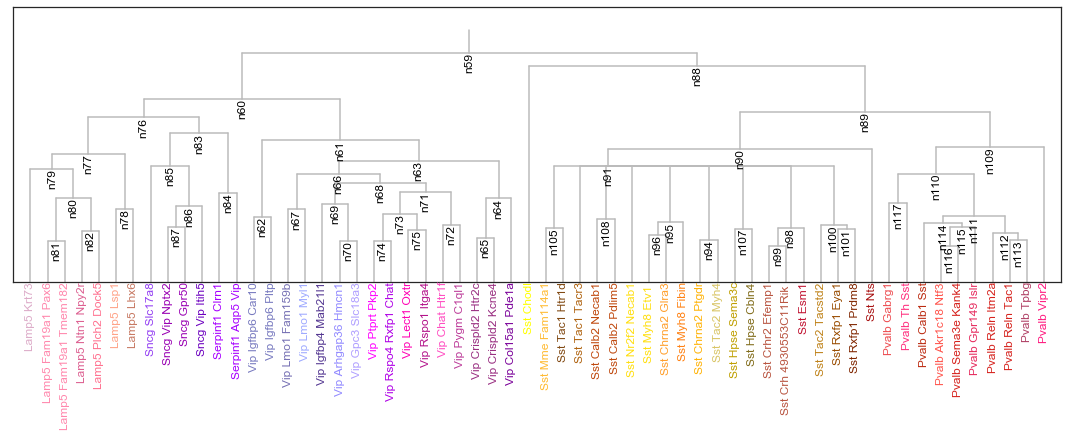

In [15]:
htree = HTree(htree_file='/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv')
htree = htree.get_subtree(node='n59')
htree.plot((15,5),fontsize=12)
descendants = htree.get_all_descendants(leafonly=True)

In [16]:
grp_cols = [htree.col[htree.child=='Lamp5 Fam19a1 Tmem182'],
    htree.col[htree.child=='Sncg Slc17a8'],
    htree.col[htree.child=='Vip Igfbp4 Mab21l1'],
    htree.col[htree.child=='Sst Nr2f2 Necab1'],
    htree.col[htree.child=='Pvalb Reln Itm2a']]
grp_cols = np.concatenate(grp_cols)
grps = ['Lamp5','Sncg + Serpinf','Vip','Sst','Pvalb']
class_id = np.zeros((np.size(valind),))
for i,class_name in enumerate(['n77','n83','n61','n90','n109']):
    these_inds = np.isin(O['cluster'][valind],descendants[class_name])
    class_id[these_inds]=i

In [17]:
X = XrE[:,:-1]
Y = O['E_dat'][valind,:]
yref = np.mean((X-Y)**2,axis=0)
srtord = np.argsort(yref)

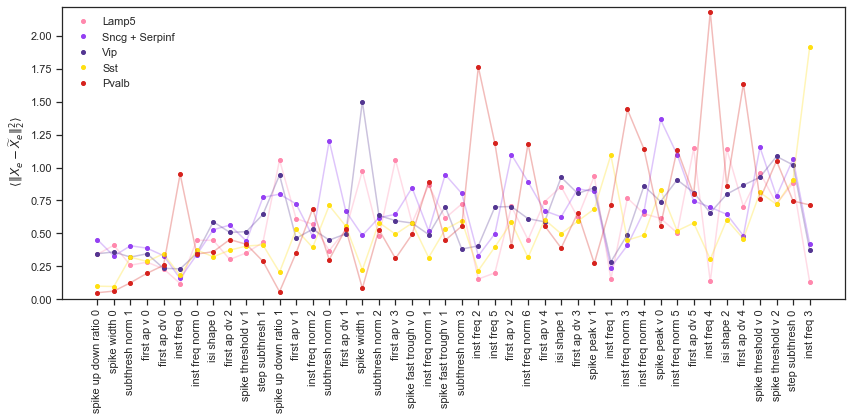

In [18]:
fig=plt.figure(figsize=(12,6))

for i,class_name in enumerate(['n77','n83','n61','n90',can we please put n109']):
    X = XrE[class_id==i,:-1]
    Y=O['E_dat'][valind[class_id==i],:]
    yy = np.mean((X-Y)**2,axis=0)
    xx = np.arange(44)
    plt.plot(xx,yy[srtord],color=grp_cols[i],linestyle='None',marker='.',markersize=8,label=grps[i])
    plt.plot(xx,yy[srtord],color=grp_cols[i],alpha=0.3)
ax = plt.gca()
ax.set_xticks(np.arange(len(E_feature_list[:-1])))
E_feature_names = np.array(E_feature_list[:-1])
E_feature_names = E_feature_names[srtord]
ax.set_xticklabels(E_feature_names,rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} - \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.22)
plt.legend(edgecolor='None')
plt.tight_layout()
fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_cs_1-0_class-wise.png',dpi=300)

In [19]:
aE = '1-0'

X = np.empty(shape=(9,E_features_names.size))
Xcm = np.empty(shape=(9,E_features_names.size))
Y = np.empty(shape=(9,E_features_names.size))
Z = np.empty(shape=(9,E_features_names.size))
for cv in range(9):
    csTE = '1-0'    
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    Xcm[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE_from_XT'][D['val_ind'],:-1]),axis=0) 

In [20]:
#Within modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

yy2=np.mean(Xcm,axis=0)
err2=np.std(Xcm,axis=0)/np.sqrt(Xcm.shape[0])

xx = np.arange(yy.size)

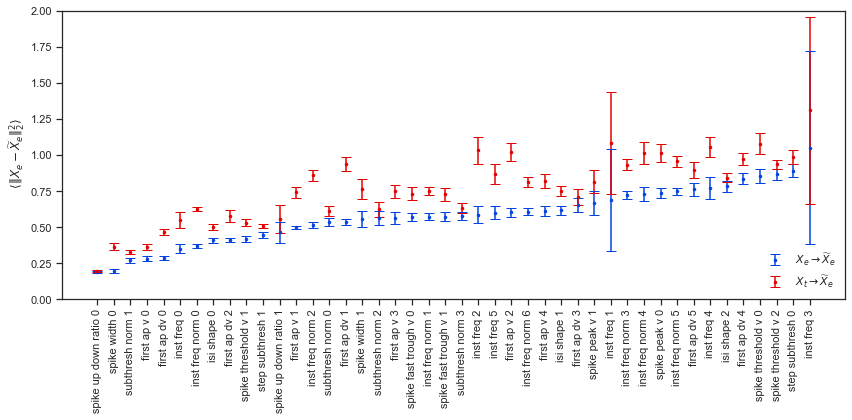

In [24]:
cols = ['#0343df','#e50000']
fig=plt.figure(figsize=(12,6))
srtord = np.argsort(yy)
#srtord = np.arange(0,yy.size)
plt.errorbar(xx,yy[srtord],err[srtord],c=cols[0],capsize=5,ls='',marker='.',ms=5,label=r'$X_{e} \rightarrow \widetilde{X}_e$')
plt.errorbar(xx,yy2[srtord],err2[srtord],c=cols[1],capsize=5,ls='',marker='.',ms=5,label=r'$X_{t} \rightarrow \widetilde{X}_e$')

ax = plt.gca()
ax.set_xticks(np.arange(len(E_feature_list[:-1])))
E_feature_names = np.array(E_feature_list[:-1])
ax.set_xticklabels(E_feature_names[srtord],rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} - \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.00)
plt.legend(loc='lower right',edgecolor='None')
plt.tight_layout()
fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_crossmodal.png',dpi=300)

In [22]:
X = np.random.normal(scale=1,size=(2000,1))
Y = np.random.normal(scale=1,size=(2000,1))
print('Baseline is random normal. MSE = {:0.3f}'.format(
    np.mean((X-Y)**2)))

X = np.random.normal(scale=1,size=(2000,1))
Y = np.random.normal(scale=1,size=(2000,1))
print('Baseline is constant=0. MSE = {:0.3f}'.format(
    np.mean((X-0)**2)))

Baseline is random normal. MSE = 1.970
Baseline is constant=0. MSE = 0.987


In [103]:
O['cluster'][np.sum(np.isnan(O['E_dat']),axis=1)>0]

array(['Sst Calb2 Necab1', 'Lamp5 Lsp1', 'Lamp5 Plch2 Dock5',
       'Sst Crhr2 Efemp1', 'Pvalb Reln Itm2a', 'Sst Chodl', 'Sncg Gpr50',
       'Sncg Vip Itih5', 'Sncg Vip Itih5', 'Sncg Vip Nptx2', 'Sncg Gpr50',
       'Sncg Vip Itih5', 'Pvalb Th Sst', 'Lamp5 Fam19a1 Pax6',
       'Sncg Vip Nptx2', 'Sncg Vip Itih5'], dtype=object)

In [116]:
def set_ME_labels(O):
    import scipy.io as sio
    import pandas as pd

    dir_pth = {}
    #/allen/programs/celltypes/workgroups/ivscc/nathang/me_clust_output/inh_met_mouse_me_clustering/refined_text_labels.csv
    dir_pth['data'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
    ME = pd.read_csv(dir_pth['data']+'refined_text_labels.csv')
    ME.columns = ['spec_id_label','cluster']
    MEdict = {'spec_id_label':ME['spec_id_label'].values,'cluster':ME['cluster'].values}

    ind = np.isin(O['E_spec_id_label'],MEdict['spec_id_label'])
    print('{:d} cells have ME labels'.format(np.sum(ind)))
    O['ME_cluster'] = np.array(['NA']*np.size(O['E_spec_id_label']),dtype='object')
    for e in O['E_spec_id_label']:
        set_ind = (MEdict['spec_id_label']==e)
        if np.sum(set_ind)==1:
            O['ME_cluster'][O['E_spec_id_label']==e] = MEdict['cluster'][set_ind]
    return O

In [117]:
D = set_ME_labels(O.copy())

349 cells have ME labels


In [69]:
O['T_dat'].shape

(3411, 1252)